# Investigating the benefit of using class_weights with a basic CNN to identify COVID-19 from coughs

Model reads in image files that have been created from cough audio files.
Machine learning is applied to create a classifier. The aim of weighting the classes is to give more weight to the COVID-19 class.

This Model does not use ImageDataGenerator. It reads the files from directories instead.

Mounting the Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Create paths to images in directories and visualize a few images.

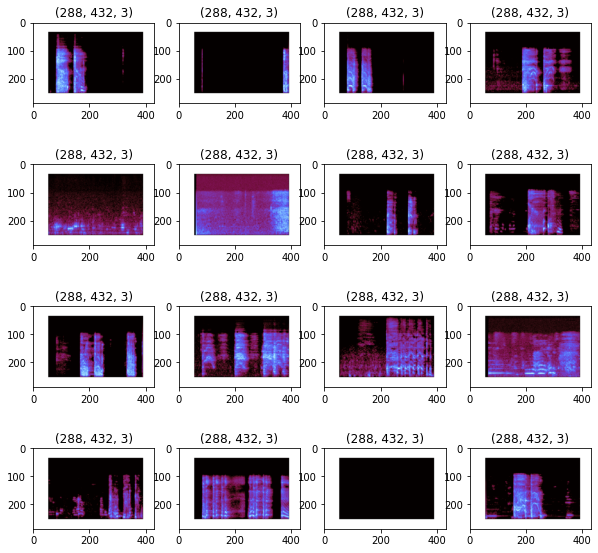

In [2]:
# Always run this code.
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from contextlib import redirect_stdout
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn.metrics import roc_curve

folder = '/content/drive/My Drive/Colab Notebooks/COVID-19'
if not os.path.exists(folder):
  print(folder + ' does not exist')

train_folder = os.path.join(folder, 'train')
if not os.path.exists(train_folder):
  print(train_folder + ' does not exist')

test_folder = os.path.join(folder, 'test')
if not os.path.exists(test_folder):
  print(test_folder + ' does not exist')

train_healthy_images = os.listdir(os.path.join(train_folder,'healthy'))
train_covid_images = os.listdir(os.path.join(train_folder,'covid'))
test_healthy_images = os.listdir(os.path.join(test_folder,'healthy'))
test_covid_images = os.listdir(os.path.join(test_folder,'covid'))

plt.figure(figsize=(10,10))
for i in range(4): 
    plt.subplot(4,4,i+1)
    filename = os.path.join(os.path.join(train_folder,'healthy'),train_healthy_images[i])
    if not os.path.exists(filename):
      print ('No such file:'+filename)   
    image = imread(filename)
    plt.title(image.shape)
    plt.imshow(image)

for i in range(4,8): 
    plt.subplot(4,4,i+1)
    filename = os.path.join(os.path.join(train_folder,'covid'),train_covid_images[i])
    if not os.path.exists(filename):
      print ('No such file:'+filename)   
    image = imread(filename)
    plt.title(image.shape)
    plt.imshow(image)

for i in range(8,12): 
    plt.subplot(4,4,i+1)
    filename = os.path.join(os.path.join(test_folder,'healthy'),test_healthy_images[i])
    if not os.path.exists(filename):
      print ('No such file:'+filename)   
    image = imread(filename)
    plt.title(image.shape)
    plt.imshow(image)

for i in range(12,16): 
    plt.subplot(4,4,i+1)
    filename = os.path.join(os.path.join(test_folder,'covid'),test_covid_images[i])
    if not os.path.exists(filename):
      print ('No such file:'+filename)   
    image = imread(filename)
    plt.title(image.shape)
    plt.imshow(image)
    
plt.show()



# Creating Datasets

In [3]:
# Always run this code.

batch_size = 100
img_height = 288
img_width = 432

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_folder,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_folder,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_folder,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11401 files belonging to 2 classes.
Using 7981 files for training.
Found 11401 files belonging to 2 classes.
Using 3420 files for validation.
Found 1000 files belonging to 2 classes.


['covid', 'healthy']


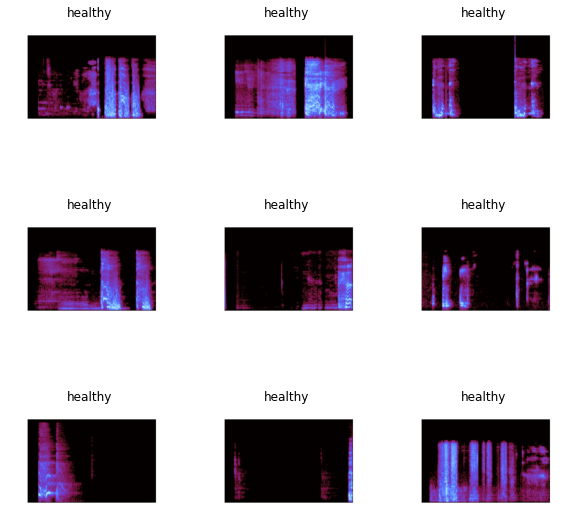

In [4]:
# Always run this code.
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# **Check distribution of classes in datasets.**

In [5]:
def class_distribution(dataset):
    class_values = []
    total_batches = dataset.__len__().numpy()
    for batch, element in enumerate(dataset.as_numpy_iterator()):
        if batch+1 == total_batches:
            for i in range(len(element[1])):
                class_values.append(class_names[int(element[1][i])])
        else:
            for i in range(batch_size):
                class_values.append(class_names[int(element[1][i])])

    class_n, frequency = np.unique(np.array(class_values), return_counts=True)
    frequency = frequency/len(class_values)
    return pd.DataFrame(frequency, class_n, columns=["Percentage"])

train_ds_class_dist = class_distribution(train_ds)
val_ds_class_dist = class_distribution(val_ds)
test_ds_class_dist = class_distribution(test_ds)

print('train:\n',train_ds_class_dist)
print('\nval:\n', val_ds_class_dist)
print('\ntest:\n',test_ds_class_dist)

train:
          Percentage
covid      0.103496
healthy    0.896504

val:
          Percentage
covid      0.095614
healthy    0.904386

test:
          Percentage
covid         0.114
healthy       0.886


Prefetching to make model faster.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# CNN Network



Although there are built in measures for precision and recall, there are not the equivalent measures of specificity and negative prediction rate so I have had to create custom metrics for those.

I have used example in (tf.keras.metrics.Metric | TensorFlow Core v2.7.0) for Precision
 and changed it to calculate the metrics I need.

In [7]:
# Always run this code.
from keras.utils import metrics_utils
from keras.utils.generic_utils import to_list
from keras import backend
class Specificity(tf.keras.metrics.Metric):
  def __init__(self,
               thresholds=None,
               top_k=None,
               class_id=None,
               name=None,
               dtype=None):
    super(Specificity, self).__init__(name=name, dtype=dtype)
    self.init_thresholds = thresholds
    self.top_k = top_k
    self.class_id = class_id

    default_threshold = 0.5 if top_k is None else metrics_utils.NEG_INF
    self.thresholds = metrics_utils.parse_init_thresholds(
        thresholds, default_threshold=default_threshold)
    self._thresholds_distributed_evenly = (
        metrics_utils.is_evenly_distributed_thresholds(self.thresholds))
    self.true_negatives = self.add_weight(
        'true_negatives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)
    self.false_positives = self.add_weight(
        'false_positives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)

  def update_state(self, y_true, y_pred, sample_weight=None):
    """Accumulates true positive and false positive statistics.
    Args:
      y_true: The ground truth values, with the same dimensions as `y_pred`.
        Will be cast to `bool`.
      y_pred: The predicted values. Each element must be in the range `[0, 1]`.
      sample_weight: Optional weighting of each example. Defaults to 1. Can be a
        `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
        be broadcastable to `y_true`.
    Returns:
      Update op.
    """
    return metrics_utils.update_confusion_matrix_variables(
        {
            metrics_utils.ConfusionMatrix.TRUE_NEGATIVES: self.true_negatives,
            metrics_utils.ConfusionMatrix.FALSE_POSITIVES: self.false_positives
        },
        y_true,
        y_pred,
        thresholds=self.thresholds,
        thresholds_distributed_evenly=self._thresholds_distributed_evenly,
        top_k=self.top_k,
        class_id=self.class_id,
        sample_weight=sample_weight)

  def result(self):
    result = tf.math.divide_no_nan(
        self.true_negatives,
        tf.math.add(self.true_negatives, self.false_positives))
    return result[0] if len(self.thresholds) == 1 else result

  def reset_state(self):
    num_thresholds = len(to_list(self.thresholds))
    backend.batch_set_value([(v, np.zeros((num_thresholds,)))
                             for v in (self.true_negatives,
                                       self.false_positives)])

  def get_config(self):
    config = {
        'thresholds': self.init_thresholds,
        'top_k': self.top_k,
        'class_id': self.class_id
    }
    base_config = super(Specificity, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [8]:
# Always run this code.
from keras.utils import metrics_utils
from keras.utils.generic_utils import to_list
from keras import backend
class NPV(tf.keras.metrics.Metric):
  def __init__(self,
               thresholds=None,
               top_k=None,
               class_id=None,
               name=None,
               dtype=None):
    super(NPV, self).__init__(name=name, dtype=dtype)
    self.init_thresholds = thresholds
    self.top_k = top_k
    self.class_id = class_id

    default_threshold = 0.5 if top_k is None else metrics_utils.NEG_INF
    self.thresholds = metrics_utils.parse_init_thresholds(
        thresholds, default_threshold=default_threshold)
    self._thresholds_distributed_evenly = (
        metrics_utils.is_evenly_distributed_thresholds(self.thresholds))
    self.true_negatives = self.add_weight(
        'true_negatives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)
    self.false_negatives = self.add_weight(
        'false_negatives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)

  def update_state(self, y_true, y_pred, sample_weight=None):
    """Accumulates true positive and false positive statistics.
    Args:
      y_true: The ground truth values, with the same dimensions as `y_pred`.
        Will be cast to `bool`.
      y_pred: The predicted values. Each element must be in the range `[0, 1]`.
      sample_weight: Optional weighting of each example. Defaults to 1. Can be a
        `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
        be broadcastable to `y_true`.
    Returns:
      Update op.
    """
    return metrics_utils.update_confusion_matrix_variables(
        {
            metrics_utils.ConfusionMatrix.TRUE_NEGATIVES: self.true_negatives,
            metrics_utils.ConfusionMatrix.FALSE_NEGATIVES: self.false_negatives
        },
        y_true,
        y_pred,
        thresholds=self.thresholds,
        thresholds_distributed_evenly=self._thresholds_distributed_evenly,
        top_k=self.top_k,
        class_id=self.class_id,
        sample_weight=sample_weight)

  def result(self):
    result = tf.math.divide_no_nan(
        self.true_negatives,
        tf.math.add(self.true_negatives, self.false_negatives))
    return result[0] if len(self.thresholds) == 1 else result

  def reset_state(self):
    num_thresholds = len(to_list(self.thresholds))
    backend.batch_set_value([(v, np.zeros((num_thresholds,)))
                             for v in (self.true_negatives,
                                       self.false_negatives)])

  def get_config(self):
    config = {
        'thresholds': self.init_thresholds,
        'top_k': self.top_k,
        'class_id': self.class_id
    }
    base_config = super(NPV, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

# **Metrics available for use**

In [9]:
# Always run this cell.
precision = tf.keras.metrics.Precision(name = "precision")
recall = tf.keras.metrics.Recall(name = "recall")
specificity = Specificity(name = "specificity")
TP = tf.keras.metrics.TruePositives(name = "TP") 
FP = tf.keras.metrics.FalsePositives(name = "FP")
FN = tf.keras.metrics.FalseNegatives(name = "FN")
TN = tf.keras.metrics.TrueNegatives(name = "TN")
auc = tf.keras.metrics.AUC(name = "auc")
npv = NPV(name = "NPV")

# **Create and compile model**

In [10]:
#Run this cell to create model or use next cell to load existing model.
model_name = "Covid_Model_9a.h5" #Change name here for each new model

model = keras.Sequential([              

    #Rescale the pixel values (integers between 0 and 255) to [0,1]. 
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), 
    
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape =[288,432,3]),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Four
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Five
    layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Head
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid'),
])

model._name= model_name[:-3]

model_plots_folder = os.path.join(folder,'model_plots')

# Save model summaries to a text file.
with open(os.path.join(model_plots_folder,'Model_summaries.txt'), 'a') as f:
    with redirect_stdout(f):
        model.summary()

# Save model plots to individual png files.
plot_model(
    model,
    to_file=(os.path.join(model_plots_folder, model_name[:-3] + ".png")),
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

model.summary()
plot_model(model, show_shapes=True)

es_callback = EarlyStopping(monitor = 'val_auc',
                            mode='max',
                            min_delta = 0.01,
                            patience = 10,
                            restore_best_weights = True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=[TP, FP, FN, TN, 
             npv, specificity, 
             recall, auc
             ]
)

model_folder = '/content/drive/My Drive/Colab Notebooks/models/'
#initial_weights = os.path.join(model_folder, 'initial_weights')
#model.load_weights(initial_weights) #Initial weights created in colab notebook: Detecting_COVID_CNN_bias_initializer.

Model: "Covid_Model_9a"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 288, 432, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 288, 432, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 288, 432, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 144, 216, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 142, 214, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 142, 214, 64)  

# **Create class weights**

In [11]:
train_healthy_folder = os.path.join(train_folder,'healthy')
train_covid_folder = os.path.join(train_folder,'covid')

def count_files(directory):
  count = 0
  for path in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, path)):
        count += 1
  return count

healthy = count_files(train_healthy_folder)
covid = count_files(train_covid_folder)

print(healthy, covid)

10248 1153


In [12]:
#Create class weights

total = healthy + covid

#Model_7
weight_for_healthy = (1 / healthy) * (total / 2.0)
weight_for_covid = (1 / covid) * (total / 2.0)

#Model_8

#weight_for_healthy = 0.5
#weight_for_covid = 50

#Model_9
#weight_for_healthy = 0.5
#weight_for_covid = 10

class_weight={0: weight_for_covid, 1: weight_for_healthy}

print('Weight for healthy: {:.2f}'.format(weight_for_healthy))
print('Weight for covid: {:.2f}'.format(weight_for_covid))


Weight for healthy: 0.56
Weight for covid: 4.94


# **Fit model to the training dataset**

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks = [es_callback],
    epochs = 30,
    class_weight=class_weight
)

model.save(model_folder + model_name)


Epoch 1/30
80/80 [==============================] - 65s 422ms/step - loss: 0.9240 - TP: 3102.0000 - FP: 312.0000 - FN: 4053.0000 - TN: 514.0000 - NPV: 0.1125 - specificity: 0.6223 - recall: 0.4335 - auc: 0.5329 - val_loss: 3.3970 - val_TP: 0.0000e+00 - val_FP: 0.0000e+00 - val_FN: 3093.0000 - val_TN: 327.0000 - val_NPV: 0.0956 - val_specificity: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.4876
Epoch 2/30
80/80 [==============================] - 27s 339ms/step - loss: 0.6853 - TP: 3691.0000 - FP: 302.0000 - FN: 3464.0000 - TN: 524.0000 - NPV: 0.1314 - specificity: 0.6344 - recall: 0.5159 - auc: 0.6006 - val_loss: 2.4930 - val_TP: 0.0000e+00 - val_FP: 0.0000e+00 - val_FN: 3093.0000 - val_TN: 327.0000 - val_NPV: 0.0956 - val_specificity: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.4985
Epoch 3/30
80/80 [==============================] - 27s 338ms/step - loss: 0.6765 - TP: 4182.0000 - FP: 345.0000 - FN: 2973.0000 - TN: 481.0000 - NPV: 0.1393 - specificity: 0.5823 - recall: 0.5845 - auc: 

In [ ]:
#Code to reload model created previously (to be used if not training the model in the cell above).
model_folder = '/content/drive/My Drive/Colab Notebooks/models/'

custom_objects = {"NPV": NPV, "Specificity": Specificity}
with keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model(model_folder + "Covid_Model_7.h5")

# **Evaluate the model on test dataset.**

In [14]:
_,TP,FP,FN,TN, Spec, npv, Recall, AUC = model.evaluate(test_ds)
print('Confusion Matrix: ', TP, FP, FN, TN)
print('Test NPV: %.4f' % npv)
print('Test Specificity: %.4f' % Spec)
print('Test Sensitivity: %.4f' % Recall)
print('Test ROC-AUC: %.4f' % AUC)


10/10 [==============================] - 2s 102ms/step - loss: 0.7448 - TP: 397.0000 - FP: 29.0000 - FN: 489.0000 - TN: 85.0000 - NPV: 0.1481 - specificity: 0.7456 - recall: 0.4481 - auc: 0.6456
Confusion Matrix:  397.0 29.0 489.0 85.0
Test NPV: 0.7456
Test Specificity: 0.1481
Test Sensitivity: 0.4481
Test ROC-AUC: 0.6456
